In [6]:
# Import necessary libraries
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import polars as pl
import seaborn as sns
import warnings
import tarfile

logging.basicConfig(level=logging.INFO)

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams.update(
    {
        "axes.edgecolor": "0.3",
        "axes.linewidth": 0.8,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.titleweight": "bold",
        "legend.fontsize": 10,
        "figure.dpi": 120,
        "legend.frameon": False,
    }
)

In [7]:
# unzip yahoo raw tgz file
raw_file_path = "../../datasets/Yahoo/raw/dataset.tgz"
extract_path = "../../datasets/Yahoo/"
unzip_dir = "../../datasets/Yahoo/data"

if not os.path.exists(unzip_dir):
    os.makedirs(unzip_dir)
    with tarfile.open(raw_file_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    logging.info(f"Extracted {raw_file_path} to {extract_path}")
    os.rename(
        "../../datasets/Yahoo/ydata-labeled-time-series-anomalies-v1_0",
        "../../datasets/Yahoo/data",
    )
else:
    logging.info(f"Directory {unzip_dir} already exists. Skipping extraction.")

INFO:root:Directory ../../datasets/Yahoo/data already exists. Skipping extraction.


In [8]:
# 读取Yahoo数据集示例
# 数据目录
data_dir = "../../datasets/Yahoo/data/A1Benchmark"

# 读取单个文件示例（real_28.csv）
sample_file = os.path.join(data_dir, "real_28.csv")
sample_df = pl.read_csv(sample_file)

print(f"Sample file: real_28.csv")
print(f"Shape: {sample_df.shape}")
print(f"Columns: {sample_df.columns}")
print(f"\nData types:")
print(sample_df.schema)
print(f"\nHead:")
sample_df.head(12)

Sample file: real_28.csv
Shape: (1441, 3)
Columns: ['timestamp', 'value', 'is_anomaly']

Data types:
Schema({'timestamp': Int64, 'value': Int64, 'is_anomaly': Int64})

Head:


timestamp,value,is_anomaly
i64,i64,i64
1,5,0
2,4532,0
3,17491,0
4,17454,0
5,18795,0
…,…,…
8,19954,0
9,18144,0
10,16021,0


In [9]:
# 读取指定的Yahoo时间序列文件
file_ids = [10, 23, 12, 13, 15, 28]
yahoo_data = {}

for file_id in file_ids:
    file_path = os.path.join(data_dir, f"real_{file_id}.csv")
    df = pl.read_csv(file_path)
    
    # 添加文件ID列
    df = df.with_columns(pl.lit(f"real_{file_id}").alias("file_id"))
    
    yahoo_data[file_id] = df
    
    # 打印统计信息
    total_points = len(df)
    anomaly_count = (df["label"] == 1).sum()
    anomaly_rate = anomaly_count / total_points * 100
    
    print(f"File real_{file_id}.csv:")
    print(f"  Total points: {total_points}")
    print(f"  Train points (1-1152): 1152")
    print(f"  Test points (1153-end): {total_points - 1152}")
    print(f"  Anomalies: {anomaly_count} ({anomaly_rate:.2f}%)")
    print()

print(f"Loaded {len(yahoo_data)} files successfully")

ColumnNotFoundError: "label" not found

In [ ]:
# 可视化函数：绘制Yahoo时间序列，区分训练集和测试集
def plot_yahoo_timeseries(
    data_dict, file_ids, train_cutoff=1152, figsize=(20, 18)
):
    """
    绘制Yahoo时间序列图，标记异常点，区分训练集和测试集
    
    Args:
        data_dict: 字典，key为file_id，value为DataFrame
        file_ids: 要绘制的文件ID列表
        train_cutoff: 训练集截止点（默认1152）
        figsize: 图形大小
    """
    n_files = len(file_ids)
    fig, axes = plt.subplots(n_files, 1, figsize=figsize)
    
    if n_files == 1:
        axes = [axes]
    
    # 按顺序编号：10, 11, 12, 13, 14, 15
    for idx, (ax, file_id) in enumerate(zip(axes, file_ids)):
        df = data_dict[file_id]
        
        # 提取数据
        timestamps = df["timestamp"].to_numpy()
        values = df["value"].to_numpy()
        labels = df["label"].to_numpy()
        
        # 分割训练集和测试集
        train_mask = timestamps <= train_cutoff
        test_mask = timestamps > train_cutoff
        
        # 训练集
        train_timestamps = timestamps[train_mask]
        train_values = values[train_mask]
        train_labels = labels[train_mask]
        
        # 测试集
        test_timestamps = timestamps[test_mask]
        test_values = values[test_mask]
        test_labels = labels[test_mask]
        
        # 绘制训练集（蓝色）
        if len(train_timestamps) > 0:
            ax.plot(
                train_timestamps,
                train_values,
                color="#2E86AB",
                linewidth=1.5,
                alpha=0.8,
                label="Train"
            )
            # 训练集异常点
            train_anomaly_mask = train_labels == 1
            if train_anomaly_mask.sum() > 0:
                ax.scatter(
                    train_timestamps[train_anomaly_mask],
                    train_values[train_anomaly_mask],
                    color="#E63946",
                    s=40,
                    marker="o",
                    zorder=5,
                    edgecolors="darkred",
                    linewidths=1.2
                )
        
        # 绘制测试集（绿色）
        if len(test_timestamps) > 0:
            ax.plot(
                test_timestamps,
                test_values,
                color="#06A77D",
                linewidth=1.5,
                alpha=0.8,
                label="Test"
            )
            # 测试集异常点
            test_anomaly_mask = test_labels == 1
            if test_anomaly_mask.sum() > 0:
                ax.scatter(
                    test_timestamps[test_anomaly_mask],
                    test_values[test_anomaly_mask],
                    color="#E63946",
                    s=40,
                    marker="o",
                    zorder=5,
                    edgecolors="darkred",
                    linewidths=1.2,
                    label="Anomaly" if idx == 0 else ""
                )
        
        # 添加垂直分割线标记训练/测试分界
        ax.axvline(x=train_cutoff, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.5)
        
        # 统计信息
        total_anomalies = (labels == 1).sum()
        train_anomalies = (train_labels == 1).sum()
        test_anomalies = (test_labels == 1).sum()
        
        # 设置标题 - 使用顺序编号（10, 11, 12, 13, 14, 15）
        plot_number = 10 + idx
        ax.set_title(
            f"{plot_number} | Total: {len(values)} pts | "
            f"Train: {len(train_values)} pts ({train_anomalies} anomalies) | "
            f"Test: {len(test_values)} pts ({test_anomalies} anomalies)",
            fontsize=13,
            fontweight="bold",
            pad=10
        )
        
        ax.set_xlabel("Timestamp (hours)", fontsize=12, fontweight="bold")
        ax.set_ylabel("Value", fontsize=12, fontweight="bold")
        
        # 美化图表
        ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
        ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
        
        # 去除顶部和右侧边框
        sns.despine(ax=ax)
        
        # 添加统计信息文本框
        stats_text = (
            f"Mean: {values.mean():.2f}\n"
            f"Std: {values.std():.2f}\n"
            f"Anomaly Rate: {total_anomalies/len(values)*100:.2f}%"
        )
        ax.text(
            0.02, 0.98, stats_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
        )
    
    plt.tight_layout()
    return fig

print("Visualization function defined successfully")

Visualization function defined successfully


Plotting Yahoo Time Series (files: 10, 23, 12, 13, 15, 28)


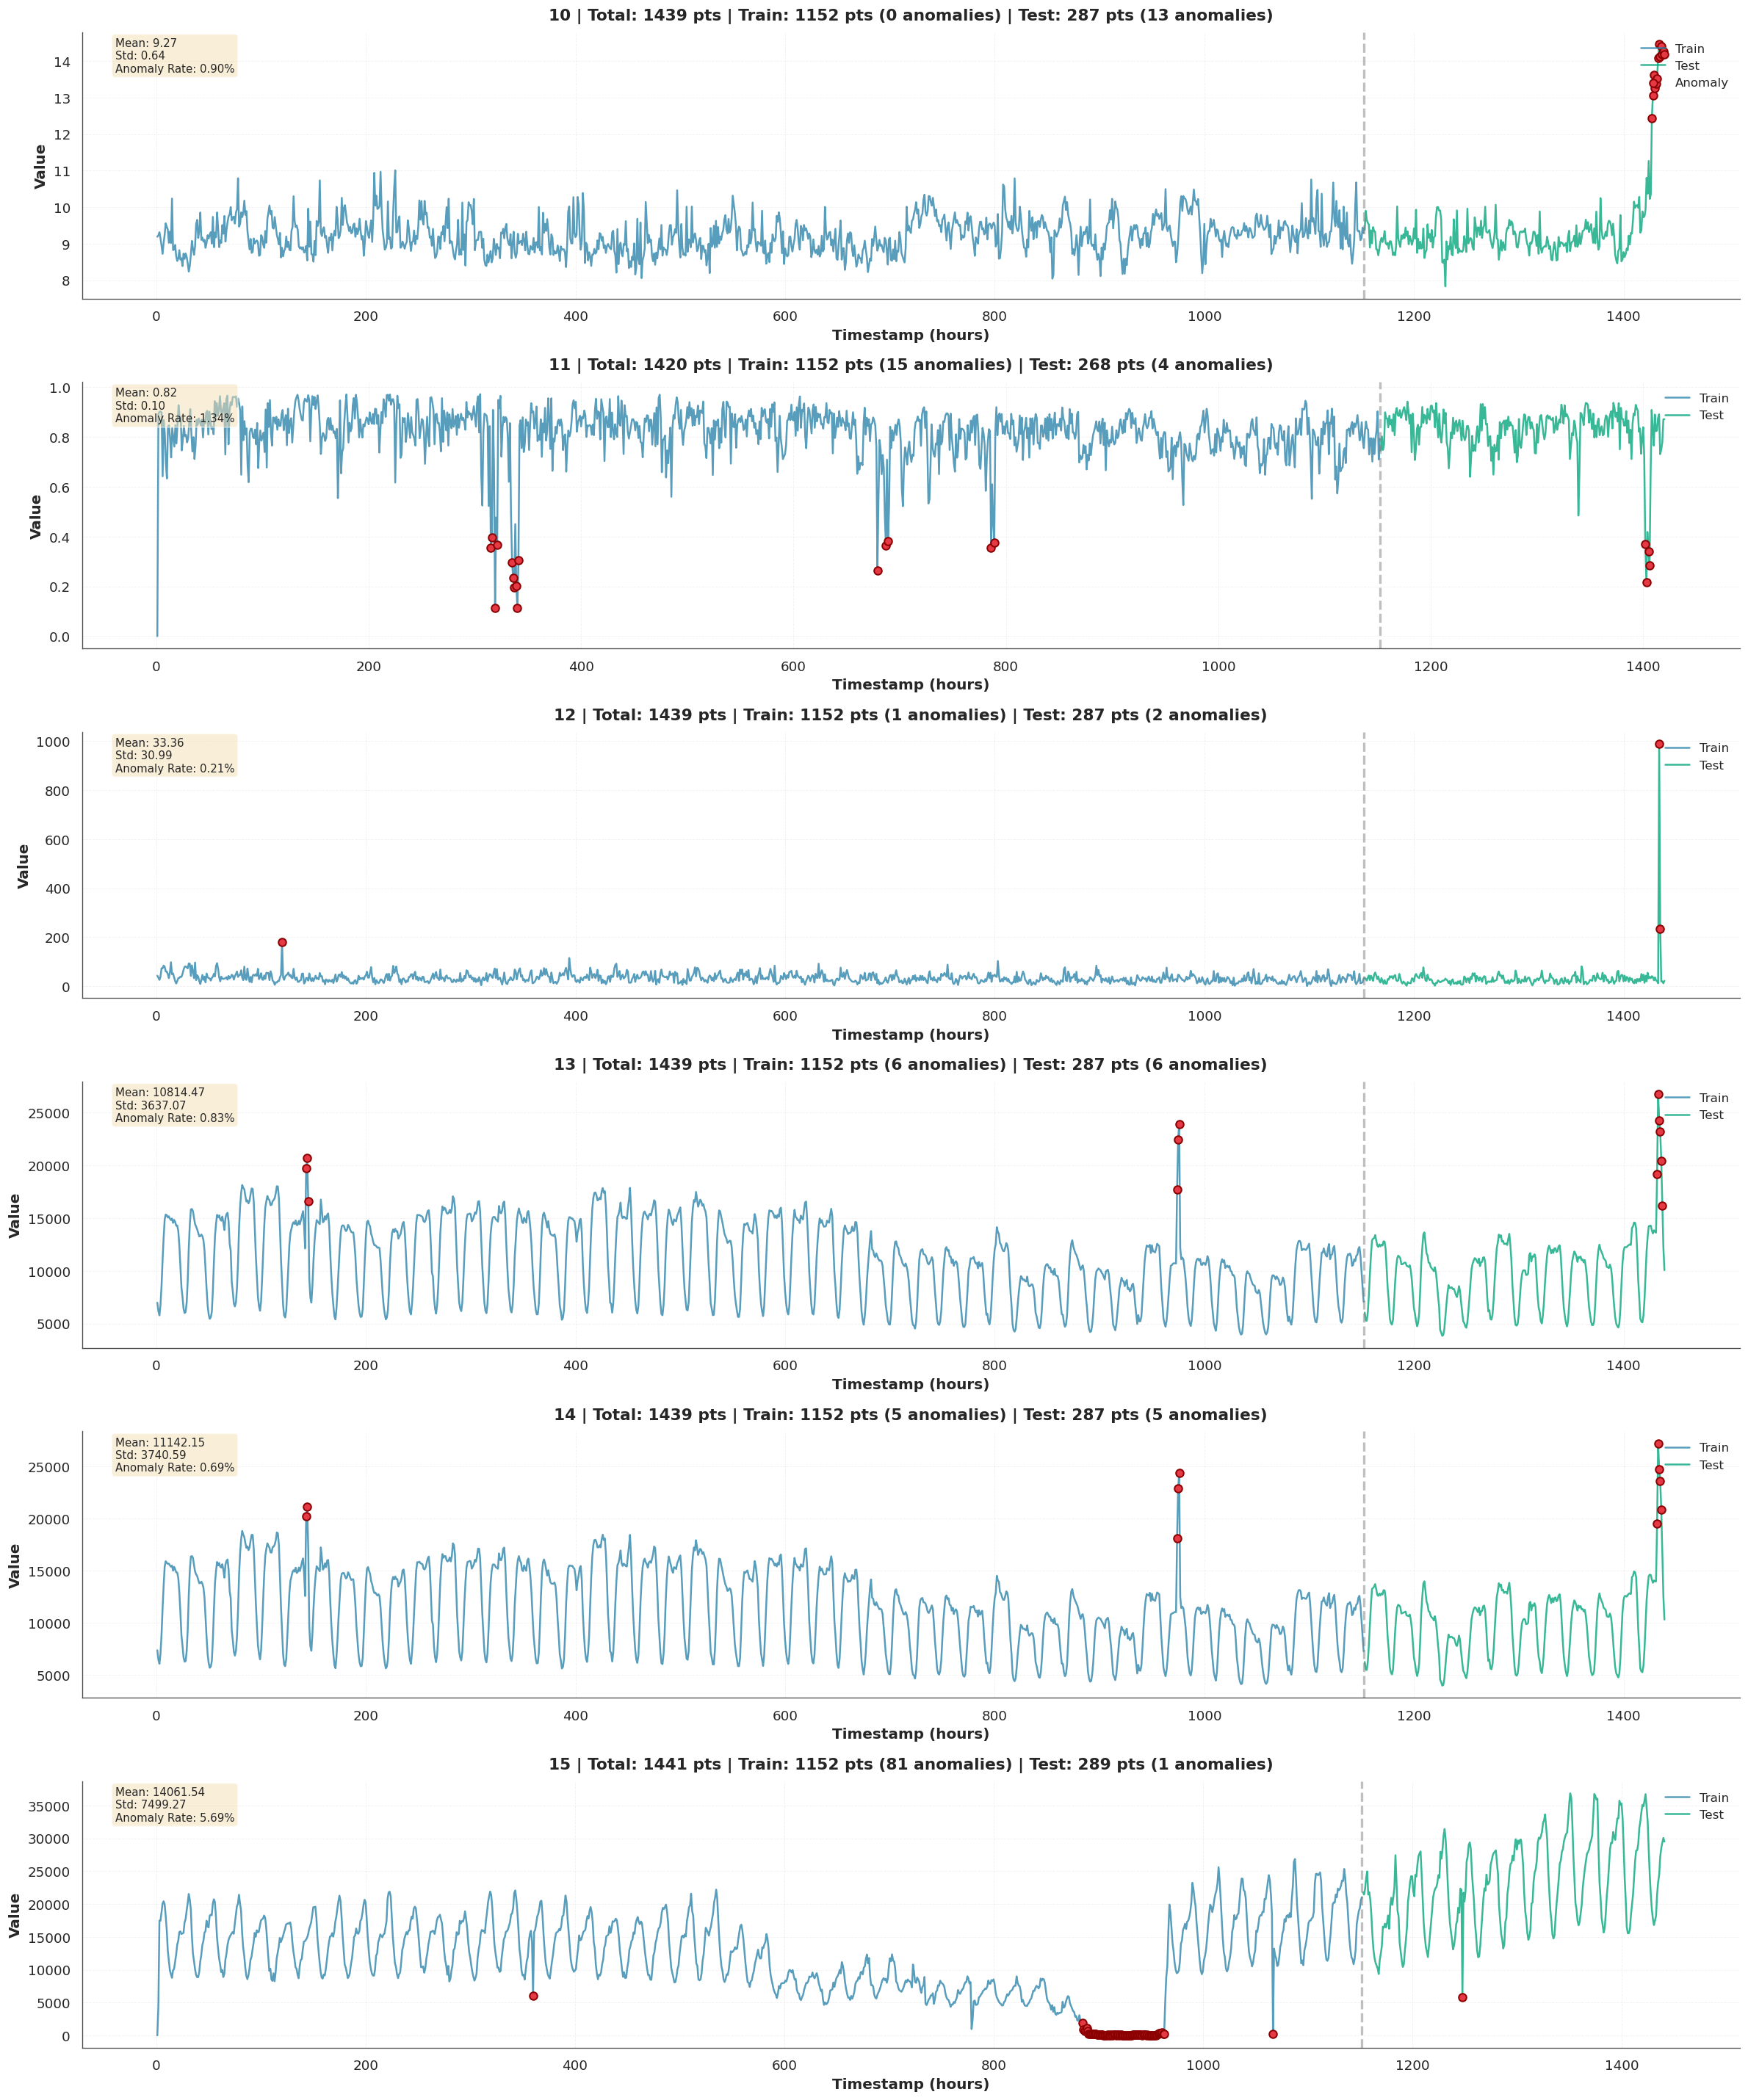


Visualization completed!


In [ ]:
# 绘制所有指定的Yahoo时间序列
print("="*60)
print("Plotting Yahoo Time Series (files: 10, 23, 12, 13, 15, 28)")
print("="*60)

fig = plot_yahoo_timeseries(
    data_dict=yahoo_data,
    file_ids=file_ids,
    train_cutoff=1152,
    figsize=(20, 24)  # 6个子图
)

plt.show()
print("\nVisualization completed!")

In [ ]:
# 可选：保存图片
output_dir = "../../datasets/Yahoo/figures"
os.makedirs(output_dir, exist_ok=True)

print("Saving Yahoo time series figure...")
fig = plot_yahoo_timeseries(
    data_dict=yahoo_data,
    file_ids=file_ids,
    train_cutoff=1152,
    figsize=(20, 24)
)
fig.savefig(
    os.path.join(output_dir, 'yahoo_timeseries_selected.png'), 
    dpi=150, 
    bbox_inches='tight'
)
plt.close(fig)

print(f"✓ Figure saved to: {output_dir}/yahoo_timeseries_selected.png")

Saving Yahoo time series figure...


✓ Figure saved to: ../../datasets/Yahoo/figures/yahoo_timeseries_selected.png


In [ ]:
# 将训练集和测试集分别保存
train_dir = "../../datasets/Yahoo/train"
test_dir = "../../datasets/Yahoo/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_cutoff = 1152

for file_id in file_ids:
    df = yahoo_data[file_id]
    
    # 分割训练集和测试集
    train_df = df.filter(pl.col("timestamp") <= train_cutoff).select(["timestamp", "value", "label"])
    test_df = df.filter(pl.col("timestamp") > train_cutoff).select(["timestamp", "value", "label"])
    
    # 保存
    train_path = os.path.join(train_dir, f"real_{file_id}.csv")
    test_path = os.path.join(test_dir, f"real_{file_id}.csv")
    
    train_df.write_csv(train_path)
    test_df.write_csv(test_path)
    
    print(f"Saved real_{file_id}: train ({len(train_df)} pts) → {train_path}")
    print(f"                     test ({len(test_df)} pts) → {test_path}")

print(f"\n✓ All files saved to {train_dir} and {test_dir}")

Saved real_10: train (1152 pts) → ../../datasets/Yahoo/train/real_10.csv
                     test (287 pts) → ../../datasets/Yahoo/test/real_10.csv
Saved real_23: train (1152 pts) → ../../datasets/Yahoo/train/real_23.csv
                     test (268 pts) → ../../datasets/Yahoo/test/real_23.csv
Saved real_12: train (1152 pts) → ../../datasets/Yahoo/train/real_12.csv
                     test (287 pts) → ../../datasets/Yahoo/test/real_12.csv
Saved real_13: train (1152 pts) → ../../datasets/Yahoo/train/real_13.csv
                     test (287 pts) → ../../datasets/Yahoo/test/real_13.csv
Saved real_15: train (1152 pts) → ../../datasets/Yahoo/train/real_15.csv
                     test (287 pts) → ../../datasets/Yahoo/test/real_15.csv
Saved real_28: train (1152 pts) → ../../datasets/Yahoo/train/real_28.csv
                     test (289 pts) → ../../datasets/Yahoo/test/real_28.csv

✓ All files saved to ../../datasets/Yahoo/train and ../../datasets/Yahoo/test


In [ ]:
# 详细统计信息
import pandas as pd

stats_list = []

for file_id in file_ids:
    df = yahoo_data[file_id]
    
    # 总体统计
    total_points = len(df)
    total_anomalies = (df["label"] == 1).sum()
    
    # 训练集统计
    train_df = df.filter(pl.col("timestamp") <= 1152)
    train_points = len(train_df)
    train_anomalies = (train_df["label"] == 1).sum()
    
    # 测试集统计
    test_df = df.filter(pl.col("timestamp") > 1152)
    test_points = len(test_df)
    test_anomalies = (test_df["label"] == 1).sum()
    
    stats_list.append({
        "File": f"real_{file_id}",
        "Total Points": total_points,
        "Total Anomalies": total_anomalies,
        "Anomaly Rate (%)": f"{total_anomalies/total_points*100:.2f}",
        "Train Points": train_points,
        "Train Anomalies": train_anomalies,
        "Test Points": test_points,
        "Test Anomalies": test_anomalies,
    })

# 转换为DataFrame便于查看
stats_df = pl.DataFrame(stats_list)
print("="*80)
print("Yahoo Time Series Statistics Summary")
print("="*80)
stats_df

Yahoo Time Series Statistics Summary


File,Total Points,Total Anomalies,Anomaly Rate (%),Train Points,Train Anomalies,Test Points,Test Anomalies
str,i64,i64,str,i64,i64,i64,i64
"""real_10""",1439,13,"""0.90""",1152,0,287,13
"""real_23""",1420,19,"""1.34""",1152,15,268,4
"""real_12""",1439,3,"""0.21""",1152,1,287,2
"""real_13""",1439,12,"""0.83""",1152,6,287,6
"""real_15""",1439,10,"""0.69""",1152,5,287,5
"""real_28""",1441,82,"""5.69""",1152,81,289,1
